In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.datasets import mnist

In [ ]:
class MLP(object):

    def __init__(self, layers):
        self.layers = layers #[dim0,dim1,dim2,.....dmL] layers dimensions list: dim0 for input and dimL for output , it would be added in self.fit() fucntion
        self.parameters = {} # dictionary for storing W and b for each layer
        self.L = len(self.layers) #L =number of layers 
        self.m = 0 #number of sampels in input , it would be set in self.fit() fucntion
        self.t_costs = [] #training cost history for iteration
        self.v_costs = [] #validation cost history for iteration
        self.t_acc   = [] #training accuracy history for iteration
        self.v_acc   = [] #validation accuracy history for iteration

    def sigmoid(self, Z):
        eta=np.min(Z) #to avoid division by inf
        return np.exp(eta) / (np.exp(eta) + np.exp(-Z+eta))

    def sigmoid_derivative(self, Z):
        s =self.sigmoid(Z) 
        return s * (1 - s)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z)) #to avoid division by inf
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def initialize_parameters(self):
        np.random.seed(1)
        for l in range(1, len(self.layers)):#l=1,2,3,...L
            self.parameters[f"W{l}"] = np.random.randn(self.layers[l], self.layers[l - 1]) / \
                np.sqrt(self.layers[l - 1])
            self.parameters[f"b{l}"] = np.zeros((self.layers[l], 1))

    def forward(self, X):
        #Z: input of layer and  A:output of layer
        store = {}
        #input is layer 0 and have no actvation function
        A = X
        for l in range(1,self.L): #l=1,2,3,...,L-1
            Z = self.parameters[f"W{l}"].dot(A) + self.parameters[f"b{l}"]  #Z[l]=dot(W[l],A(l-1))+b[l]
            A = self.sigmoid(Z) #A[l]=g(Z[l])  ,g:sigmond
            store[f"A{l}"] = A
            store[f"W{l}"] = self.parameters[f"W{l}"]
            store[f"Z{l}"] = Z
        #for output layer
        Z = self.parameters[f"W{self.L}"].dot(A) + \
            self.parameters[f"b{self.L}"]
        A = self.softmax(Z) #soft max for output
        store[f"A{self.L}"] = A
        store[f"W{self.L}"] = self.parameters[f"W{self.L}"]
        store[f"Z{self.L}"] = Z

        return A, store  #return output and history of net 

    def backward(self, X, Y, store):

        derivatives = {}  #dJ/dw and dJ/db for each layer
        store["A0"] = X

        A = store[f"A{self.L}"] # start from output layer
        dZ = A - Y  #dJ/dZ at output layer
        dW = dZ.dot(store[f"A{self.L - 1}"].T) / self.m #dJ/dw= dot(dJ/dZ[L],A[L-1])/m
        db = np.sum(dZ, axis=1, keepdims=True) / self.m #dJ/db=sum(dJ/dZ)[L]/m
        dAPrev = store["W" + str(self.L)].T.dot(dZ)     #dJ/dA[L-1]=dot(W.T[L] ,dJ/dZ)[L]) (for previous layer)
        derivatives[f"dW{self.L}"] = dW
        derivatives[f"db{self.L}"] = db

        for l in range(self.L - 1, 0, -1): #l=L-1,L-2,...1
            dZ = dAPrev * self.sigmoid_derivative(store[f"Z{l}"]) #dJ/dZ=dJ/dA[l]*g'(Z[l])
            dW = 1. / self.m * dZ.dot(store[f"A{l-1}"].T)        #dJ/dw= dot(dJ/dZ[l],A[l-1])/m
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True) #dJ/db=sum(dJ/dZ)[l]/m
            if l > 1:
                dAPrev = store[f"W{l}"].T.dot(dZ)               #dJ/dA[l-1]=dot(W.T[l] ,dJ/dZ)[l]) (for previous layer)

            derivatives[f"dW{l}"] = dW
            derivatives[f"db{l}"] = db

        return derivatives
   ########################################
    #decay=lambda*lr/m ==> lambda=decay*m/lr , 0<decay<=1
    #decay=0 <==> No regulazation
    #adaptive=true ==> learning_rate increas or decreas depend on increas or decreas training cost 
    #validiation_set; tapel of X_val and Y_val
    #########################################
    def fit(self, X, Y, learning_rate=0.1,adaptive=False,decay=0 ,epochs=2500,validation_set=None):
        alpha=0.01*learning_rate # for adaptive =True
        beta=0.95 # for adaptive =True
        np.random.seed(1)
        
        X_val=None
        Y_val=None
        if validation_set: # validiation_set != None
            X_val=validation_set[0]
            Y_val=validation_set[1]
            
        self.m = X.shape[1]  #set number of train sampels
        self.layers.insert(0, X.shape[0]) #set the input layer dimansion "dim0"
        
        #initialize weights and biases and make net parameters 
        self.initialize_parameters()
        
        t_cost,t_accuracy,v_cost,v_accuracy=0.0,0.0,0.0,0.0
        K=5# for smoothing curves of cost and accuracy by mean 
        for epoch in range(epochs):
            #forward step
            A, store = self.forward(X)
            #backward step
            derivatives = self.backward(X, Y, store)
            
            #cost and accuracy calculation
            #train set
            t_cost += -np.mean(Y * np.log(A + 1e-8)) # an epsilon value added for avoiding log 0
            t_accuracy += (np.argmax(A, axis=0) == np.argmax(Y, axis=0)).mean() 
            #validation set
            if validation_set:
                y_p,_=self.forward(X_val)
                v_cost += -np.mean(Y_val * np.log(y_p + 1e-8))
                v_accuracy += (np.argmax(y_p, axis=0) == np.argmax(Y_val, axis=0)).mean()
            
            #optimaiz model
            for l in range(1, self.L + 1):
                #W[n+1]=(1-decay)*W[n]-learning_rate*dJ/dW[n]
                self.parameters[f"W{l}"] = (1-decay)*self.parameters[f"W{l}"] - \
                    learning_rate * derivatives[f"dW{l}"]
                #b[n+1]=b[n]-learning_rate*dJ/db[n]
                self.parameters[f"b{l}"] = self.parameters[f"b{l}"] - \
                    learning_rate * derivatives[f"db{l}"]
            
            if epoch % K ==(K-1):
                t_cost,t_accuracy,v_cost,v_accuracy=t_cost/K,t_accuracy/K,v_cost/K,v_accuracy/K #just for smoothing curves and better discussion
                if validation_set:
                    print(f"Epoch: {epoch} :: train Cost: {t_cost},train acc: {t_accuracy} , val cost: {v_cost} ,val acc: {v_accuracy}")
                    self.v_costs.append(v_cost)
                    self.v_acc.append(v_accuracy)
                else:
                    print(f"Epoch: {epoch} :: train Cost: {t_cost},train acc: {t_accuracy}")
                    
                self.t_costs.append(t_cost)
                self.t_acc.append(t_accuracy)
                t_cost,t_accuracy,v_cost,v_accuracy=0.0,0.0,0.0,0.0
                #adaptive learning_rate
                if(adaptive and len(self.t_costs)>2):
                    if(self.t_costs[-1]>self.t_costs[-2]): #if cost increase learning_rate decrease
                        learning_rate=beta*learning_rate
                        if(decay!=0):
                            momentum=decay*beta  #update decay according its formula
                    else:#if cost is normaly decrease learning_rate increase
                        learning_rate=learning_rate+alpha
                        if(decay!=0):
                            decay=decay*learning_rate/(learning_rate-alpha)  #update momentum according its formula
                    
                        
    def predict(self, X, Y):
        A, _ = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=0)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100

    def plot_cost(self):
        plt.figure()
        plt.plot(self.t_costs, color = "r", label='Training Loss')
        if self.v_costs:
            plt.plot(self.v_costs, color = "b",label='validation Loss')
        plt.title('Loss  per iteration')
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.legend(loc="best")
        plt.show()
        
    def plot_acc(self):
        plt.figure()
        plt.plot(self.t_acc, color = "r", label='Training accuracy')
        if self.v_acc:
            plt.plot(self.v_acc, color = "b",label='validation accuracy')
        plt.title('accuracy per iteration')
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend(loc="best")
        plt.show()

#### visualizing tool

In [ ]:
#show image and label
def visualize(images,labels):
    for i in range(min(len(images),9)):
        plt.subplot(330 + 1 + i)
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
        plt.text(0, 0, labels[i], color='black',bbox=dict(facecolor='white', alpha=1))
    plt.show()
    
#show image and label prediction
def visualize_prediction(images,True_labels,predict_label):
    for i in range(min(len(images),9)):
        plt.subplot(330 + 1 + i)
        color='red'  #red for false predict
        if True_labels[i]==predict_label[i]:
            color='green' #green for true predict
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
        plt.text(0, 0, predict_label[i], color=color,bbox=dict(facecolor='white', alpha=1))
    plt.show()

In [ ]:

# read data (images)and split it to train and test
def getMnistData():
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    return train_images, train_labels, test_images, test_labels

# In this function the image will reshaped (flatted). Let's say if they are 28 * 28 Pixels so it convert to 1* 784 
def reshapeImages(images):
    images = images.reshape(images.shape[0], -1)
    return images

def reshapedMnistData(train_images, train_labels, test_images, test_labels):
    train_images = reshapeImages(train_images)
    train_labels = reshapeImages(train_labels)
    test_images = reshapeImages(test_images)
    test_labels = reshapeImages(test_labels)
    return train_images, train_labels, test_images, test_labels



#   here after we flattened our data ,We normed our entries inputs according to highest values 255 because here our data set are images zero and 255 black and gray color pixel
# then we need to make them to one hot encode  
def preprocess(train_images, train_labels, test_images, test_labels):
    x_train, y_train, x_test, y_test=reshapedMnistData(train_images, train_labels, test_images, test_labels)
    # Normalize
    x_train = x_train / 255.
    x_test = x_test / 255.

    enc = OneHotEncoder(sparse=False, categories='auto')
    y_train = enc.fit_transform(y_train.reshape(len(y_train), -1))

    y_test = enc.transform(y_test.reshape(len(y_test), -1))

    return x_train, y_train, x_test, y_test

#### import data set and pre_preprocess

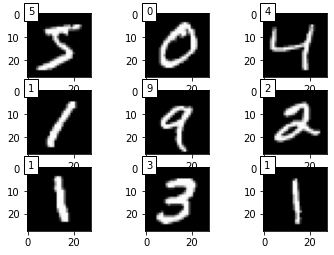

x_train: (784, 60000)
y_train: (10, 60000)
x_test: (784, 10000)
y_test: (10, 10000)


In [ ]:
train_images, train_labels, test_images, test_labels = getMnistData()
x_train, y_train, x_test, y_test = preprocess(train_images, train_labels, test_images, test_labels)
visualize(train_images,train_labels)
#transpose need for input of MLP cllas
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")


###### test #1  learning_rate=0.1, epochs=500

Epoch: 0 :: train Cost: 0.04801745573713957,train acc: 0.0199 , val cost: 0.04802011188291348 ,val acc: 0.0198
Epoch: 5 :: train Cost: 0.2327256821484281,train acc: 0.12139666666666667 , val cost: 0.2326463279977383 ,val acc: 0.12268000000000001
Epoch: 10 :: train Cost: 0.22545052579278582,train acc: 0.18506999999999998 , val cost: 0.22525748371794233 ,val acc: 0.188
Epoch: 15 :: train Cost: 0.2208312112896313,train acc: 0.30245 , val cost: 0.220545756366958 ,val acc: 0.3099
Epoch: 20 :: train Cost: 0.21707390224576492,train acc: 0.4163833333333334 , val cost: 0.2167030256468399 ,val acc: 0.425
Epoch: 25 :: train Cost: 0.21365221003017112,train acc: 0.4646533333333333 , val cost: 0.21319896603794802 ,val acc: 0.47278000000000003
Epoch: 30 :: train Cost: 0.2103869328457766,train acc: 0.5013466666666666 , val cost: 0.20985320059740897 ,val acc: 0.50792
Epoch: 35 :: train Cost: 0.2072085182015912,train acc: 0.5322833333333333 , val cost: 0.2065958989986154 ,val acc: 0.5381400000000001
Epo

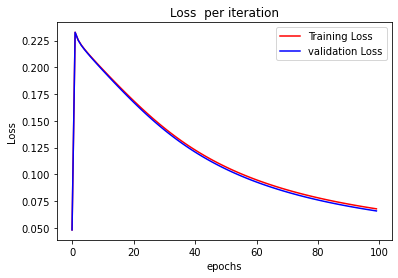

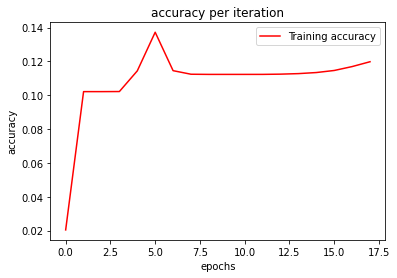

In [ ]:
layers_dims = [28, 10]
mlp1 = MLP(layers_dims)
mlp1.fit(x_train, y_train, learning_rate=0.1, epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp1.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp1.predict(x_test, y_test)}")
mlp1.plot_cost()
mlp2.plot_acc()

###### test #2 learning_rate=0.1, epochs=500
layers_dims = [56,28, 10]

Epoch: 0 :: train Cost: 0.046984055074539455,train acc: 0.020436666666666665 , val cost: 0.04698266723588909 ,val acc: 0.020200000000000003
Epoch: 5 :: train Cost: 0.23247088745506125,train acc: 0.10218333333333333 , val cost: 0.2324479046287314 ,val acc: 0.101
Epoch: 10 :: train Cost: 0.23066004400140075,train acc: 0.10218333333333333 , val cost: 0.23062559289687007 ,val acc: 0.101
Epoch: 15 :: train Cost: 0.22996528474450112,train acc: 0.10223333333333333 , val cost: 0.22992648434131455 ,val acc: 0.10102
Epoch: 20 :: train Cost: 0.22960580347117232,train acc: 0.11444666666666667 , val cost: 0.2295636791927639 ,val acc: 0.11385999999999999
Epoch: 25 :: train Cost: 0.22935927815787557,train acc: 0.13728333333333334 , val cost: 0.22931332778717506 ,val acc: 0.13594
Epoch: 30 :: train Cost: 0.22915218000448617,train acc: 0.11457000000000002 , val cost: 0.22910168594892893 ,val acc: 0.11452
Epoch: 35 :: train Cost: 0.22895870954033187,train acc: 0.11246333333333333 , val cost: 0.228903076

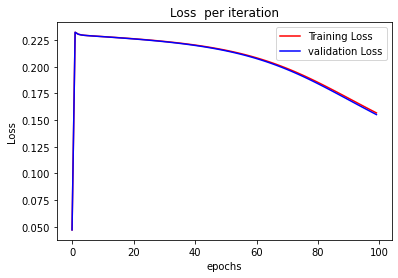

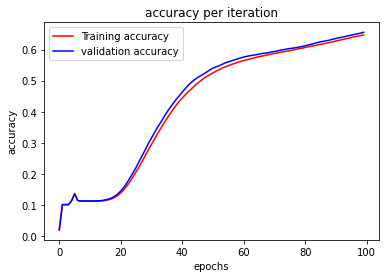

In [ ]:
layers_dims = [56,28, 10]
mlp2 = MLP(layers_dims)
mlp2.fit(x_train, y_train, learning_rate=0.1, epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp2.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp2.predict(x_test, y_test)}")
mlp2.plot_cost()
mlp2.plot_acc()

###### test #3
layers_dims = [112,56,28, 10]
learning_rate=0.1, epochs=500

Epoch: 0 :: train Cost: 0.04732745881682879,train acc: 0.020436666666666665 , val cost: 0.04732373491453655 ,val acc: 0.020200000000000003
Epoch: 5 :: train Cost: 0.23435145143165387,train acc: 0.10218333333333333 , val cost: 0.2343302450951983 ,val acc: 0.101
Epoch: 10 :: train Cost: 0.2320994479767382,train acc: 0.10218333333333333 , val cost: 0.2320759009817 ,val acc: 0.101
Epoch: 15 :: train Cost: 0.23103276889410215,train acc: 0.08717 , val cost: 0.23100903901533126 ,val acc: 0.08684
Epoch: 20 :: train Cost: 0.2305308750097303,train acc: 0.11236666666666668 , val cost: 0.2305080445285325 ,val acc: 0.1135
Epoch: 25 :: train Cost: 0.23029598335373191,train acc: 0.11236666666666668 , val cost: 0.23027432734403724 ,val acc: 0.1135
Epoch: 30 :: train Cost: 0.23018423994940784,train acc: 0.11236666666666668 , val cost: 0.23016363096297504 ,val acc: 0.1135
Epoch: 35 :: train Cost: 0.23012785737713615,train acc: 0.11236666666666668 , val cost: 0.23010803187008255 ,val acc: 0.1135
Epoch: 4

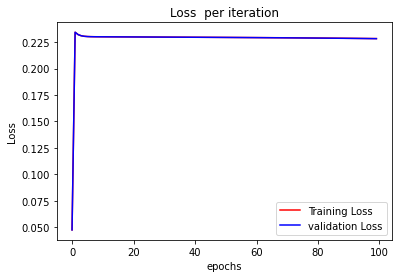

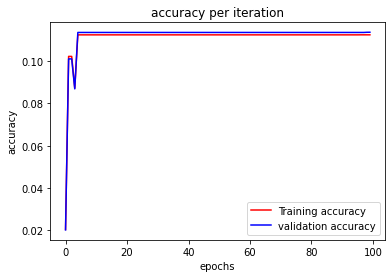

In [ ]:
layers_dims = [112,56,28, 10]
mlp3 = MLP(layers_dims)
mlp3.fit(x_train, y_train, learning_rate=0.1, epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp3.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp3.predict(x_test, y_test)}")
mlp3.plot_cost()
mlp3.plot_acc()

###### The lower hidden layars achieved better result 
Therefore I chose the test #1 with one hidden layer.For my next test I will try to find the best configeration by changing the number of nodes only.I will keep the number of hidden leyares the same as test #1 which is 1.

###### test #4  : one hiden layer :50 dim
learning_rate=0.1

Epoch: 0 :: train Cost: 0.04802857961146739,train acc: 0.01784 , val cost: 0.048078550585095345 ,val acc: 0.01788
Epoch: 5 :: train Cost: 0.23198026688651194,train acc: 0.09140666666666666 , val cost: 0.23201741065197323 ,val acc: 0.09022000000000001
Epoch: 10 :: train Cost: 0.22537443289077905,train acc: 0.18649999999999997 , val cost: 0.2252125771347561 ,val acc: 0.18584
Epoch: 15 :: train Cost: 0.22151933944518146,train acc: 0.4031366666666666 , val cost: 0.22124339078600613 ,val acc: 0.40922000000000003
Epoch: 20 :: train Cost: 0.21818529975666728,train acc: 0.4935033333333333 , val cost: 0.21782525170404982 ,val acc: 0.50664
Epoch: 25 :: train Cost: 0.21494478505051298,train acc: 0.53375 , val cost: 0.2145128635622179 ,val acc: 0.54672
Epoch: 30 :: train Cost: 0.21171013820311285,train acc: 0.55671 , val cost: 0.2112117385045032 ,val acc: 0.56896
Epoch: 35 :: train Cost: 0.2084583442375667,train acc: 0.5748633333333333 , val cost: 0.20789601018253823 ,val acc: 0.58698
Epoch: 40 ::

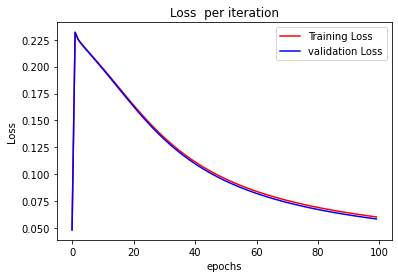

In [ ]:

layers_dims = [50, 10]
mlp4 = MLP(layers_dims)
mlp4.fit(x_train, y_train, learning_rate=0.1,epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp4.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp4.predict(x_test, y_test)}")
mlp4.plot_cost()

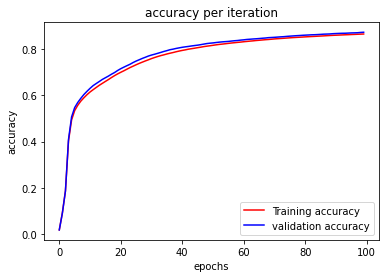

In [ ]:
mlp4.plot_acc()

 Test#5: one hidden layer with 100 hidden unites

Epoch: 0 :: train Cost: 0.04908494782489005,train acc: 0.020136666666666667 , val cost: 0.04901166588586432 ,val acc: 0.02042
Epoch: 5 :: train Cost: 0.23159087908649267,train acc: 0.13662333333333335 , val cost: 0.23132302898476675 ,val acc: 0.13840000000000002
Epoch: 10 :: train Cost: 0.2256097279207855,train acc: 0.25044333333333335 , val cost: 0.2253815553078305 ,val acc: 0.25495999999999996
Epoch: 15 :: train Cost: 0.22219922410107826,train acc: 0.32692333333333334 , val cost: 0.22192081838662384 ,val acc: 0.33386
Epoch: 20 :: train Cost: 0.2188846090181548,train acc: 0.42039333333333334 , val cost: 0.21853509099895593 ,val acc: 0.422
Epoch: 25 :: train Cost: 0.21556148130155042,train acc: 0.48902 , val cost: 0.21513724433631992 ,val acc: 0.49413999999999997
Epoch: 30 :: train Cost: 0.21220916359714045,train acc: 0.5405833333333334 , val cost: 0.2117100322170007 ,val acc: 0.54722
Epoch: 35 :: train Cost: 0.20881318503170454,train acc: 0.5796733333333334 , val cost: 0.2082395992559

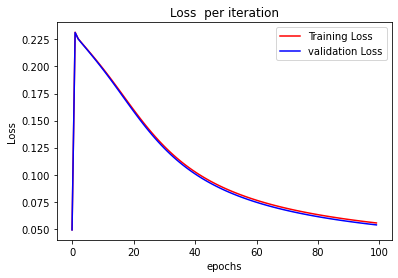

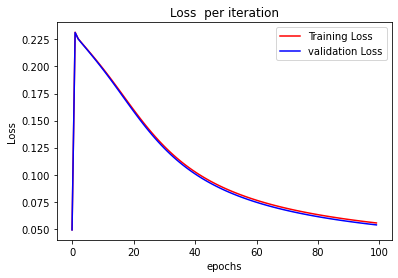

In [ ]:
layers_dims = [100, 10]
mlp5 = MLP(layers_dims)
mlp5.fit(x_train, y_train, learning_rate=0.1,epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp5.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp5.predict(x_test, y_test)}")
mlp5.plot_cost()
mlp5.plot_cost()

Test#6:one hidden layer with 200 hidden unites

Epoch: 0 :: train Cost: 0.24253350022630887 , val cost: 0.24238643426243467
Epoch: 5 :: train Cost: 0.3984318471149227 , val cost: 0.39575127139198113
Epoch: 10 :: train Cost: 0.23456609213621332 , val cost: 0.23402413899246413
Epoch: 15 :: train Cost: 0.17278585666261073 , val cost: 0.1712602903234636
Epoch: 20 :: train Cost: 0.1551439921662095 , val cost: 0.15389124758922246
Epoch: 25 :: train Cost: 0.13217519667538144 , val cost: 0.13002813116981016
Epoch: 30 :: train Cost: 0.11713830031956662 , val cost: 0.11547433429859813
Epoch: 35 :: train Cost: 0.10291539904452822 , val cost: 0.10087148315242808
Epoch: 40 :: train Cost: 0.09049335088947644 , val cost: 0.08847180850044262
Epoch: 45 :: train Cost: 0.08733895683438574 , val cost: 0.08549587090125968
Training Accuracy: 74.78
Testing Accuracy: 75.33


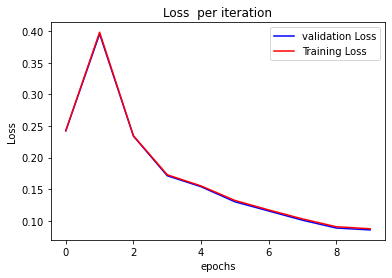

In [ ]:
layers_dims = [200, 10]
mlp6 = MLP(layers_dims)
mlp6.fit(x_train, y_train, learning_rate=0.1,epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp6.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp6.predict(x_test, y_test)}")
mlp6.plot_cost()
mlp6.plot_acc()

Test#7

In [ ]:
layers_dims = [300, 10]
mlp7 = MLP(layers_dims)
mlp7.fit(x_train, y_train, learning_rate=0.1 ,epochs=1000,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp7.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp7.predict(x_test, y_test)}")
mlp7.plot_cost()
mlp7.plot_acc()

Epoch: 0 :: train Cost: 0.04850670004526177,train acc: 0.019473333333333336 , val cost: 0.04847728685248693 ,val acc: 0.019639999999999998
Epoch: 5 :: train Cost: 0.22831624863964867,train acc: 0.1754 , val cost: 0.22811457237892876 ,val acc: 0.18558
Epoch: 10 :: train Cost: 0.22391385192275956,train acc: 0.3050066666666667 , val cost: 0.22360178721037408 ,val acc: 0.3256
Epoch: 15 :: train Cost: 0.21970341598972443,train acc: 0.42636666666666667 , val cost: 0.2193009859697978 ,val acc: 0.44706
Epoch: 20 :: train Cost: 0.21551637681295205,train acc: 0.5022033333333333 , val cost: 0.21502574960615878 ,val acc: 0.52552
Epoch: 25 :: train Cost: 0.2113254597151498,train acc: 0.5517533333333333 , val cost: 0.21074825167695788 ,val acc: 0.57528
Epoch: 30 :: train Cost: 0.20710955456549507,train acc: 0.5867633333333334 , val cost: 0.206447008275667 ,val acc: 0.60818
Epoch: 35 :: train Cost: 0.2028535517131138,train acc: 0.61356 , val cost: 0.2021066881294565 ,val acc: 0.63358
Epoch: 40 :: tra

Test#8: Here I chose the configuration with one hidden leyar that include the 100 hidden units was my best configuration. I changed the learnong factor to learning_factor= 0.01.
I reciveved Training Accuracy: 65.71833333333333
Testing Accuracy: 66.97 which is much lower than the test#5

In previouse configuration test#5 with learning factor=0.1 
Training Accuracy: 86.93833333333333
Testing Accuracy: 87.64 
So I recived the lower accuracy when I reduced the value of learning factor.

Epoch: 0 :: train Cost: 0.04908494782489005,train acc: 0.020136666666666667 , val cost: 0.04901166588586432 ,val acc: 0.02042
Epoch: 5 :: train Cost: 0.24278046582337195,train acc: 0.10194 , val cost: 0.2424249764598942 ,val acc: 0.10346
Epoch: 10 :: train Cost: 0.23922668299632374,train acc: 0.10465333333333333 , val cost: 0.23888944400695228 ,val acc: 0.10528
Epoch: 15 :: train Cost: 0.23655636686498394,train acc: 0.10827 , val cost: 0.2362367536147965 ,val acc: 0.1101
Epoch: 20 :: train Cost: 0.23451505816278898,train acc: 0.11235666666666666 , val cost: 0.23421182658682943 ,val acc: 0.11266000000000001
Epoch: 25 :: train Cost: 0.2329266954844793,train acc: 0.11609666666666667 , val cost: 0.23263822566178086 ,val acc: 0.11701999999999999
Epoch: 30 :: train Cost: 0.23166728638339915,train acc: 0.11984666666666666 , val cost: 0.23139176579640292 ,val acc: 0.12083999999999999
Epoch: 35 :: train Cost: 0.23064836105535563,train acc: 0.12361333333333333 , val cost: 0.23038391437075506 ,va

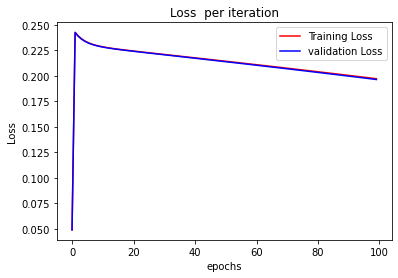

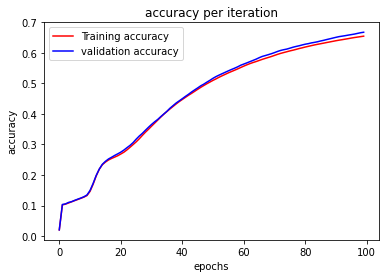

In [ ]:
layers_dims = [100, 10]
mlp8 = MLP(layers_dims)
mlp8.fit(x_train, y_train, learning_rate=0.01,epochs=500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp8.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp8.predict(x_test, y_test)}")
mlp8.plot_cost()
mlp8.plot_acc()

Test#9: I changed the learning rate=0.01  to learning_rate=1 but this time with iteration = 2000
Here I increase the value of the learning rate

Epoch: 0 :: train Cost: 0.04908494782489005,train acc: 0.020136666666666667 , val cost: 0.04901166588586432 ,val acc: 0.02042
Epoch: 5 :: train Cost: 0.237536209575444,train acc: 0.21574666666666667 , val cost: 0.237156178371937 ,val acc: 0.21983999999999995
Epoch: 10 :: train Cost: 0.18507914991179866,train acc: 0.44937666666666665 , val cost: 0.18397805064720996 ,val acc: 0.45962
Epoch: 15 :: train Cost: 0.1492211410238263,train acc: 0.6209466666666666 , val cost: 0.14767378331594944 ,val acc: 0.6304000000000001
Epoch: 20 :: train Cost: 0.12181664628273252,train acc: 0.6700233333333333 , val cost: 0.1200996552930875 ,val acc: 0.6783399999999998
Epoch: 25 :: train Cost: 0.10373853518339757,train acc: 0.6879766666666667 , val cost: 0.10209992663813212 ,val acc: 0.6929399999999999
Epoch: 30 :: train Cost: 0.0894041662981271,train acc: 0.7363266666666666 , val cost: 0.0876440457955052 ,val acc: 0.7421599999999999
Epoch: 35 :: train Cost: 0.07886529841690933,train acc: 0.7620433333333334 

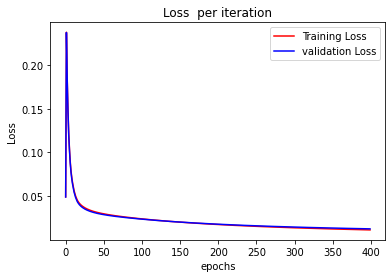

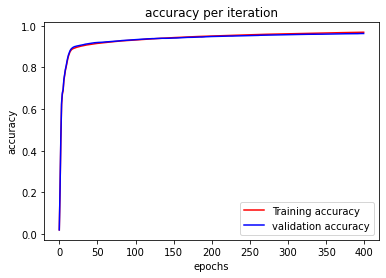

In [ ]:
layers_dims = [100, 10]
mlp10 = MLP(layers_dims)
mlp10.fit(x_train, y_train, learning_rate=1,epochs=2000,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp10.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp10.predict(x_test, y_test)}")
mlp10.plot_cost()
mlp10.plot_acc()

Epoch: 0 :: train Cost: 0.04908494782489005,train acc: 0.020136666666666667 , val cost: 0.04901166588586432 ,val acc: 0.02042
Epoch: 5 :: train Cost: 0.237536209575444,train acc: 0.21574666666666667 , val cost: 0.237156178371937 ,val acc: 0.21983999999999995
Epoch: 10 :: train Cost: 0.18507914991179866,train acc: 0.44937666666666665 , val cost: 0.18397805064720996 ,val acc: 0.45962
Epoch: 15 :: train Cost: 0.14949457463159493,train acc: 0.6144333333333334 , val cost: 0.147947003160612 ,val acc: 0.62368
Epoch: 20 :: train Cost: 0.12272750453987753,train acc: 0.65715 , val cost: 0.12101875554605154 ,val acc: 0.6651399999999998
Epoch: 25 :: train Cost: 0.10442841986935669,train acc: 0.6789833333333333 , val cost: 0.10280814750186287 ,val acc: 0.6830800000000001
Epoch: 30 :: train Cost: 0.08976513440290514,train acc: 0.7300133333333333 , val cost: 0.08802411931800751 ,val acc: 0.7354999999999999
Epoch: 35 :: train Cost: 0.07920489650512562,train acc: 0.7556333333333335 , val cost: 0.077560

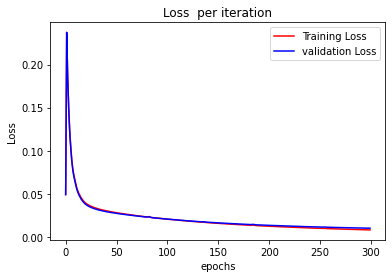

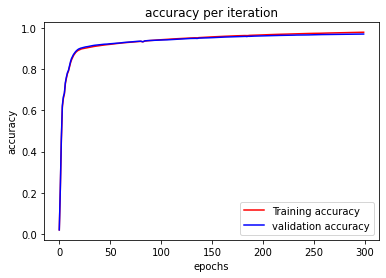

In [ ]:
# adaptive learning_rate 
# I used the adaptive learning rate technique from my Data Mining course according Alpadin Text Book page:257 and equation (11.31) I aplied the adaptive LR
# The role of the Adaptive is to increase the learning rate when loss is decreasing and vice verca
# 
layers_dims = [100, 10]
mlp11 = MLP(layers_dims)
mlp11.fit(x_train, y_train, learning_rate=1,adaptive=True ,epochs=1500,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp11.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp11.predict(x_test, y_test)}")
mlp11.plot_cost()
mlp11.plot_acc()

From above result I observed which I got the acc 96.865 very faster than of perevious configuration when I applied the addaptive learning rate. So here I just want to play with learning rate to get better acc in better iteration. Next I will test L2-NORM

Here I tried to visulaize this high acc of the model

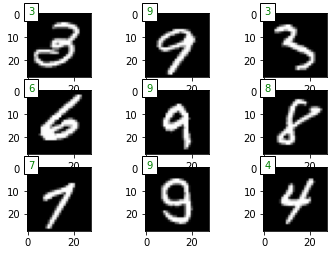

In [ ]:
from random import shuffle
test_indices = list(range(len(test_images)))
shuffle(test_indices)
random_sampel=x_test.T
random_sampel=random_sampel[test_indices]
yp,_=mlp11.forward(random_sampel.T)
predict_label= np.argmax(yp, axis=0)
visualize_prediction(test_images[test_indices],test_labels[test_indices],predict_label)

In [ ]:
#I observed  from above test that the learning rate is big and model trained defficalty even though I used regulazation 

Epoch: 4 :: train Cost: 0.23437768072536241,train acc: 0.10218333333333333 , val cost: 0.23460580924994381 ,val acc: 0.101
Epoch: 9 :: train Cost: 0.23171403831586374,train acc: 0.10218333333333333 , val cost: 0.23184628925336553 ,val acc: 0.101
Epoch: 14 :: train Cost: 0.23070696414615272,train acc: 0.10218333333333333 , val cost: 0.23078199634955898 ,val acc: 0.101
Epoch: 19 :: train Cost: 0.2303099185859681,train acc: 0.10218333333333333 , val cost: 0.23035030496496783 ,val acc: 0.101
Epoch: 24 :: train Cost: 0.23014779197802823,train acc: 0.10622333333333334 , val cost: 0.2301670109466285 ,val acc: 0.10604
Epoch: 29 :: train Cost: 0.23007626443410278,train acc: 0.11236666666666668 , val cost: 0.23008243158531352 ,val acc: 0.1135
Epoch: 34 :: train Cost: 0.23003952736952588,train acc: 0.11236666666666668 , val cost: 0.2300375517745795 ,val acc: 0.1135
Epoch: 39 :: train Cost: 0.2300161362656404,train acc: 0.11236666666666668 , val cost: 0.23000900033073818 ,val acc: 0.1135
Epoch: 44

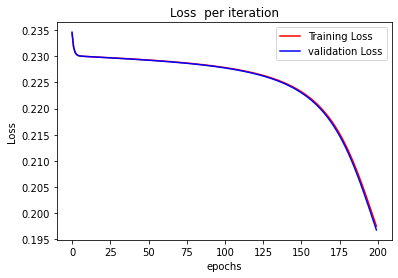

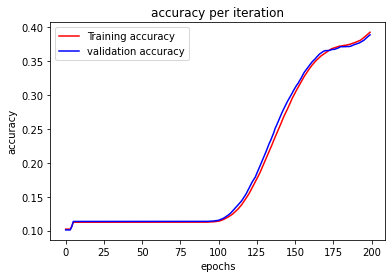

In [ ]:
layers_dims = [300,100,30,10]
mlp12 = MLP(layers_dims)
mlp12.fit(x_train, y_train, learning_rate=0.1, epochs=1000,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp12.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp12.predict(x_test, y_test)}")
mlp12.plot_cost()
mlp12.plot_acc()

## As you mentioned "lambda" is a reserved keyword in python so I decided to use "decay" name to pass it as a parameter to the function.Please see the underneath equation regarding "decay". I also Explained it in my backword function in my class as well(Above code)
## decay=lambda* lr/m ==> lambda=decay*m/lr , 0<=decay <1
## lr = Learning Factor




In [ ]:
#decay=lambda*lr/m ==> lambda=decay*m/lr , 0<=decay <1
# I chose this model layers_dims = [300,100,30, 10] for applying L2_Norm which this model did not get learn properly from data according to the previouse test result(above test)
# Training Accuracy: 39.38833333333333
# Testing Accuracy: 39.01
# I expect by applying L2_Norm model can learn better.

layers_dims = [300,100,30, 10]
mlp12 = MLP(layers_dims)
mlp12.fit(x_train, y_train, learning_rate=0.1,decay=0.05, epochs=1000,validation_set=(x_test, y_test))



Epoch: 4 :: train Cost: 0.2338383644282669,train acc: 0.10218333333333333 , val cost: 0.2340421742694827 ,val acc: 0.101
Epoch: 9 :: train Cost: 0.23109471636421391,train acc: 0.10218333333333333 , val cost: 0.23117972612105722 ,val acc: 0.101
Epoch: 14 :: train Cost: 0.23041687410840947,train acc: 0.10218333333333333 , val cost: 0.23044874723769623 ,val acc: 0.101
Epoch: 19 :: train Cost: 0.23022420074398026,train acc: 0.10218333333333333 , val cost: 0.230231019150603 ,val acc: 0.101
Epoch: 24 :: train Cost: 0.23016353387097852,train acc: 0.11236666666666668 , val cost: 0.23015831375959186 ,val acc: 0.1135
Epoch: 29 :: train Cost: 0.23014214746593642,train acc: 0.11236666666666668 , val cost: 0.2301311380999082 ,val acc: 0.1135
Epoch: 34 :: train Cost: 0.2301335222904756,train acc: 0.11236666666666668 , val cost: 0.23011975843312524 ,val acc: 0.1135
Epoch: 39 :: train Cost: 0.23012949122193146,train acc: 0.11236666666666668 , val cost: 0.23011444503344816 ,val acc: 0.1135
Epoch: 44 ::

Training Accuracy: 11.236666666666666
Testing Accuracy: 11.35


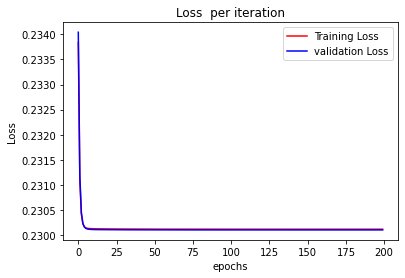

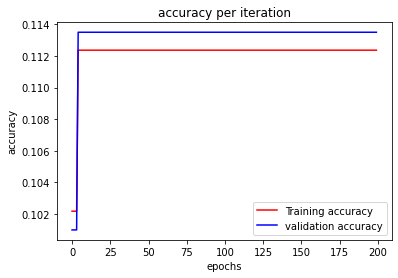

In [ ]:
print(f"Training Accuracy: {mlp12.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp12.predict(x_test, y_test)}")
mlp12.plot_cost()
mlp12.plot_acc()

I applied L2-Norm on above modele. I obsereved the speed of learning reduced after norming.Because I observed that on epoch=659 the acc = 0.19 improved to acc= 0.206 also at epoch= 749 the acc went up to 30.7. But when I compare it with that model in the similar iteration the one applied L2-Norm has lower learning I mean higher loss and lower acc. I also want to discusse about my normalization on the data sets. I applied Mean Max norm on the data to reduce loss in order to get better result which I learned it before from ML course. So I beleve IF i can not see the affect of L2_Norm clearly on this case it may cause of that earlier normalization.

In addition I can say our model was not originally over fitt which L2_Norm could not help it to learn better. 

with L2_norm regularization is an tecknique to avoid over fitting


Epoch: 4 :: train Cost: 0.24357253684548041,train acc: 0.10149999999999999 , val cost: 0.2432141416780734 ,val acc: 0.1032
Epoch: 9 :: train Cost: 0.2397119791811213,train acc: 0.10391333333333333 , val cost: 0.2393737567601944 ,val acc: 0.10444
Epoch: 14 :: train Cost: 0.23685598411483264,train acc: 0.10736000000000001 , val cost: 0.23653744898629134 ,val acc: 0.10869999999999999
Epoch: 19 :: train Cost: 0.23470783990709415,train acc: 0.11123000000000001 , val cost: 0.23440776890706103 ,val acc: 0.11223999999999998
Epoch: 24 :: train Cost: 0.23306489526290092,train acc: 0.11484333333333333 , val cost: 0.2327816305250857 ,val acc: 0.11513999999999998
Epoch: 29 :: train Cost: 0.23178617216063274,train acc: 0.11843333333333332 , val cost: 0.23151784295344488 ,val acc: 0.11978
Epoch: 34 :: train Cost: 0.2307722585746162,train acc: 0.12196333333333334 , val cost: 0.2305169340661934 ,val acc: 0.1227
Epoch: 39 :: train Cost: 0.22995231373332295,train acc: 0.12556666666666666 , val cost: 0.22

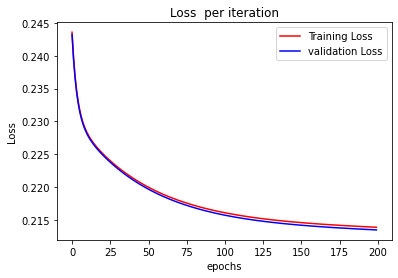

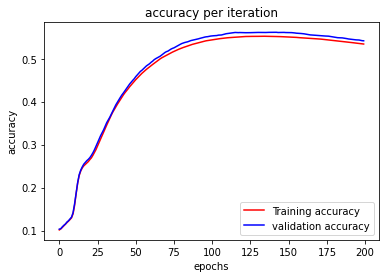

In [ ]:
# Now I will try to apply L2_NORM on test #9 which I implemented before without applying L2_Norm
# Model layers_dims = [100, 10]
# The previouse acc was Training Accuracy: 96.865
#Testing Accuracy: 96.26
layers_dims = [100, 10]
mlp8 = MLP(layers_dims)
mlp8.fit(x_train, y_train, learning_rate=0.01,decay= 0.001, epochs=1000,validation_set=(x_test, y_test))
print(f"Training Accuracy: {mlp8.predict(x_train, y_train)}")
print(f"Testing Accuracy: {mlp8.predict(x_test, y_test)}")
mlp8.plot_cost()
mlp8.plot_acc()

From above result which I got the Training Accuracy: 53.381666666666675 and 
Testing Accuracy: 54.13 compare with the original model without L2-Norm which the acc was  Training Accuracy: 96.865 Testing Accuracy: 96.26. I can conclude it that is better to apply the L2_NORM on the models which are over or under fitting . Otherwise as We can observe here We will decrease the speed of learning.

Briefly discuss which configuration worked best and why you think it worked well. Why other configurations did not work as well. - 2 points

I observed the models with more layers make the modeles more complex.I mean if the number of layers and nodes getting bigger the complexity of the models getting higher.I concluded the models with one hidden layer have the best result. In all models with one hidden layer the number of the hidden units have effect on the overall performance as well.I observed the model with one hidden layer and 100 nodes has the best performance. I can discuss that the modeles with one hidden layer but with the higher than 100 units like 300 hidden units have the higher model loss or Variance error.On the other hand the modeles with less than 100 hidden units have higher Bias error.I observed the better stability in our models get better learning from data. Therefore the modeles with one hidden layer had achieved better learning. So in the Adaptive LR (Learning Factor) approach when the loss goes down the Learning Factor accepts the more value and increases the speed of learning but if the loss gets higher the amount of LR reduces it. As a result, when the complexity of the model is high the Bias error is reduced but the Model error (Variance) increased.